In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
# Create the above tables
# meta.create_all(con)

In [19]:
def get_macds(coin = None, date = '2018-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2018-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2018-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2018-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2018-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_balances(coin, date):
    s = select([balances]) \
        .where(and_(balances.c.coin == coin,
                    balances.c.date <= date))\
        .order_by(desc(balances.c.date))
    rows = con.execute(s)
    balances_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not balances_df.empty:
        balances_df.columns = rows.keys()
    return balances_df

In [20]:
# def plot(dfs):
#     c = ['red', 'blue', 'green', 'yellow']
#     fig, ax = plt.subplots()
#     ax.xaxis.set_major_locator(mdates.DayLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
#     for i in range(len(dfs)):
#         df = dfs[i]
#         ax.plot(df.x, df.y, color = c[i])
#     ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     fig.autofmt_xdate()
#     plt.show()  

# dfs = []
# mkt_trend_df = get_mkt_trend(coin, date, 1)
# df['x'] = mkt_trend_df.date
# df['y'] = mkt_trend_df.dif_current
# dfs.append(df)
# tickers_df = get_tickers(coin, date, 0)
# df['x'] = tickers_df.date
# df['y'] = tickers_df.price
# dfs.append(df)
# long_df = get_positions(coin, 'closed', date)
# df['x'] = long_df.date_ask
# df['y'] = long_df.ask
# dfs.append(df)
# macd_df = get_macds(coin, date, 1)
# df['x'] = macd_df.date
# df['y'] = macd_df.ema_26
# dfs.append(df)
# plot(dfs)

In [21]:
def plot_market_trend(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    mkt_trend_df = get_mkt_trend(coin, date, 1)
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.bar(mkt_trend_df.date.values, mkt_trend_df.dif_current.values, color = 'red')
    
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

EXAMPLE OF SAVE

In [22]:
def plot_screen(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    tickers_df = get_tickers(coin, date, 0)
    tickers_df = tickers_df[(tickers_df.date < date) & (tickers_df.date > start_date)]
    long_df = get_positions(coin, 'closed', date)
    long_df = long_df[(long_df.date_ask < date) & (long_df.date_ask >= start_date)]
    macd_df = get_macds(coin, date, 1)
    macd_df = macd_df[(macd_df.date < date) & (macd_df.date >= start_date)]
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(tickers_df.date.values, tickers_df.price.values, color = 'green')
    ax.scatter(long_df.date_ask.values, long_df.ask.values, color = 'red')
#     ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'yellow')
    ax.scatter(long_df.exit_date.values, long_df.exit_price.values, color = 'blue')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [23]:
def plot_screen_2(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):

    macd_df = get_macds(coin, date, 1)
    macd_df = macd_df[(macd_df.date < date) & (macd_df.date >= start_date)]
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    short = ax.plot(macd_df.date.values, macd_df.ema12.values, color = 'blue', label='Short', marker = 'o')
    long = ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'red', label='Long', marker = 'o')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [24]:
def plot_screen_3(coin, start_date = datetime.today().strftime('%Y-%m-%d'), date = datetime.today().strftime('%Y-%m-%d')):

    ema_df = get_emas(coin, date, 1)
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.HourLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(ema_df.date.values, ema_df.ema20.values, color = 'red', label='Long', marker ='o')
    ax.plot(ema_df.date.values, ema_df.ema5.values, color = 'blue', marker = 'o')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [25]:
def plot_fft(coin, start, date):
    from scipy.fftpack import fft, ifft
    df = get_tickers(coin, date, 1)
    df = df[(df.date < date) & (df.date >= start)]
    time = df.date
    df = get_tickers(coin, date, 1)
    df = df[(df.date < date) & (df.date >= start)]
    time = df.date
    data = df.price
    # N = 4*60*60 # measured every 15 minutes
    yf = fft(data)
    # fig, ax = plt.subplots()
    # ax.plot(2.0/N * np.abs(yf[:N//2]), color = 'red')
    # # ax.set_xlim(0, 100)
    # plt.show() 
    wn = 18
    # yf[20:]=0
    yf[wn:-wn] = 0
    iY = ifft(yf).real
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    # long = ax.plot(macd_df.date, macd_df.ema12, color = 'blue')
    ax.plot(df.date.values, iY, color = 'red', marker = 'o')
    # ax.plot(df.date.values, df.price, color = 'blue')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d H:M:S')
    fig.autofmt_xdate()
    plt.show()

In [26]:
coin = 'USDT_BTC'
start = '2018-02-22 05:00:00'
stop = '2018-02-24 22:00:00'
plot_screen(coin, start, stop)
# stop = '2018-02-22 17:00:00'
plot_screen_2(coin, start, stop)
plot_fft(coin, start, stop)
# plot_screen_3(coin, start, stop)

AttributeError: 'DataFrame' object has no attribute 'date_ask'

In [27]:
def log_return(coin=None, date_init = '2017-01-01', date_end = '2018-12-31'):    
    long_df = get_positions(coin, 'closed', date_end)
    mkt_trend_df = get_mkt_trend(coin, date_end, 1)
#     mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
    
    merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    merged['real_return'] = np.log((200 * (1 + merged['log_return']))/(200 + 200 * 0.0015 + 200 * (1 + merged['log_return']) * 0.0025))
#     print(merged['real_return'].mean())
#     print(merged['real_return'].max())
#     print(merged['real_return'].min())
#     print((merged['real_return'] * 100).sum())
    merged = merged.drop(['id_position',
                          'size_position',
                          'date_settlement',
                          'settlement', 
                          'status',
                          'date', 
                          'screen'], axis = 1)
    return merged
    
date = '2018-01-01'
date_end = '2018-03-01'
coin = 'USDT_BTC'

# print('DATE')
log_return(None, date, date_end)
print('ALL')
df = log_return()
df

ALL


,coin_x,strategy,date_ask,ask,take_profit,stop_loss,exit_date,exit_price,log_return,coin_y,dif_current,dif_base,d_dif,theta_current,theta_base,d_theta,vote,real_return
0,USDT_LTC,CHANNEL,2018-02-27 03:30:00,217.452341,246.123328,206.579724,2018-02-28 09:35:00,205.5,-0.056534,USDT_BTC,0.004335,0.010287,-0.864178,0.569067,1.301425,-0.827217,0,-0.062046
1,USDT_LTC,CHANNEL,2018-02-27 03:30:00,217.452341,246.123328,206.579724,2018-02-28 09:35:00,205.5,-0.056534,USDT_LTC,0.026316,0.020652,0.242372,0.002412,-0.037509,-2.743922,1,-0.062046


In [28]:
date = '2017-01-01'
date_end = '2018-12-31'
coin = 'USDT_BTC'

long_df = get_positions(status='active', date=date_end)
# mkt_trend_df = get_mkt_trend(date=date_end, screen=1)
# mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'd_dif']] 
# merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
# merged['real_return'] = np.log((200 * (1 + merged['log_return']))/(200 + 200 * 0.0015 + 200 * (1 + merged['log_return']) * 0.0025))
# merged['month'] = pd.to_datetime(merged['date_ask']).dt.month
# merged['year'] = pd.to_datetime(merged['date_ask']).dt.year
long_df = long_df.groupby(['coin'])['size_position'].sum().reset_index()
long_df.size_position[0]

0.0096711798838149

In [29]:
merged.groupby(['coin', 'strategy', 'year','month'])['log_return', 'real_return'].mean().reset_index().log_return[0]

NameError: name 'merged' is not defined

In [30]:
merged.groupby(['strategy', 'year','month'])['log_return', 'real_return'].mean()

NameError: name 'merged' is not defined

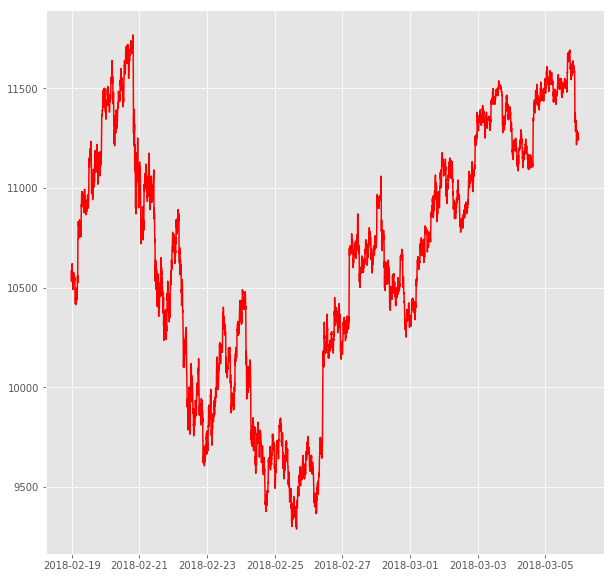

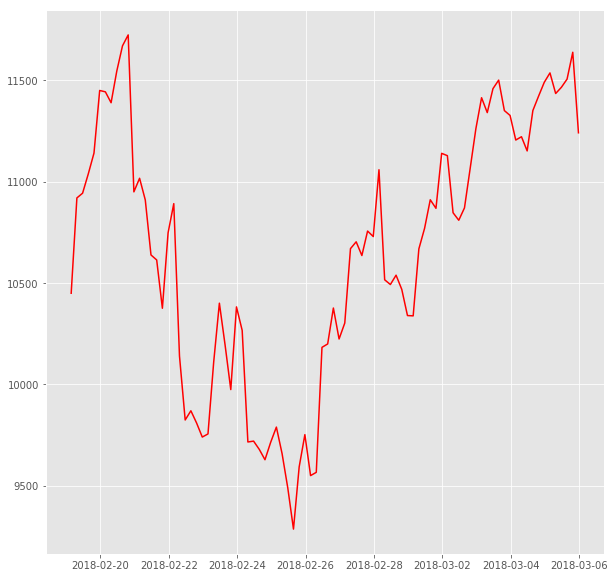

AttributeError: module 'scipy' has no attribute 'fftpack'

In [31]:
import numpy as np
import scipy
coin = 'USDT_BTC'
date = '2019-01-18'
start = '2017-01-15'
df = get_tickers(coin, date, 0)
df = df[(df.date < date) & (df.date >= start)]
time = df.date
fig, ax = plt.subplots()
ax.plot(df.date, df.price, color = 'red')
plt.show()
df = get_tickers(coin, date, 1)
df = df[(df.date < date) & (df.date >= start)]
time = df.date
fig, ax = plt.subplots()
ax.plot(df.date, df.price, color = 'red')
plt.show()
data = df.price
N = 4*60*60 # measured every 15 minutes
yf = scipy.fftpack.fft(data)
fig, ax = plt.subplots()
ax.plot(2.0/N * np.abs(yf[:N//2]), color = 'red')
# ax.set_xlim(0, 100)
plt.show() 
wn = 18
# yf[20:]=0
yf[wn:-wn] = 0
iY = scipy.fftpack.ifft(yf).real
fig, ax = plt.subplots()
# long = ax.plot(macd_df.date, macd_df.ema12, color = 'blue')
ax.plot(df.date.values, iY, color = 'red', marker = 'o')
# ax.plot(df.date.values, df.price, color = 'blue')
plt.show()

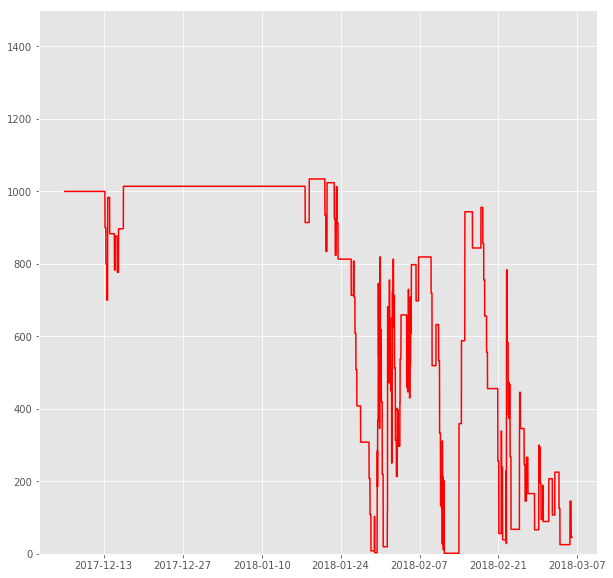

In [39]:
def plot_balance(coin, date):
    df = get_balances(coin, date)
    fig, ax = plt.subplots()
    ax.plot(df.date, df.size_position, color = 'red')
    ax.set_ylim(0, 1500)
    plt.show()
    
plot_balance('USD', '2019-01-01')